Fitting 3 folds for each of 27 candidates, totalling 81 fits
Best Parameters: {'classifier__max_depth': None, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 200}

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.95      0.96       179
           1       0.61      0.67      0.64        21

    accuracy                           0.92       200
   macro avg       0.78      0.81      0.80       200
weighted avg       0.92      0.92      0.92       200



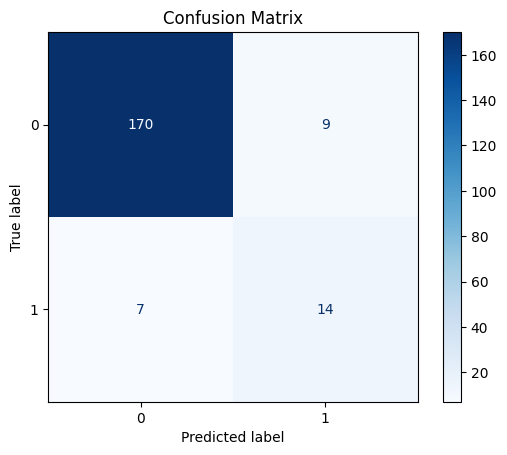

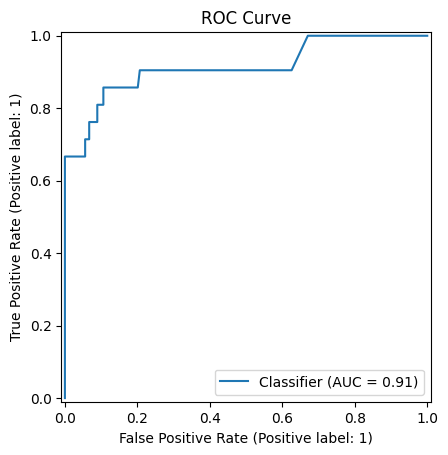

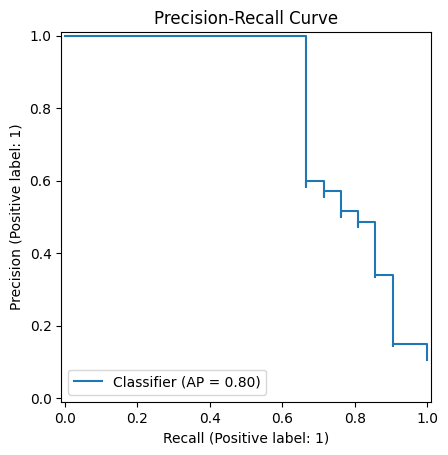

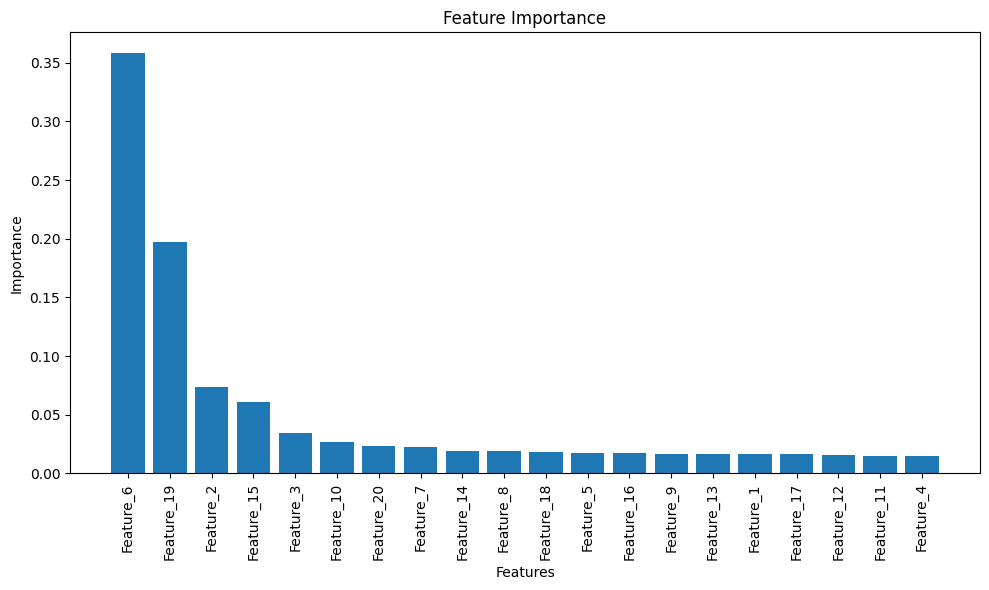

C:\Users\tahsi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
5 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\tahsi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\tahsi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "C:\Users\tahsi\AppData\Local\Programs\Python\Python310\lib\site-packages\

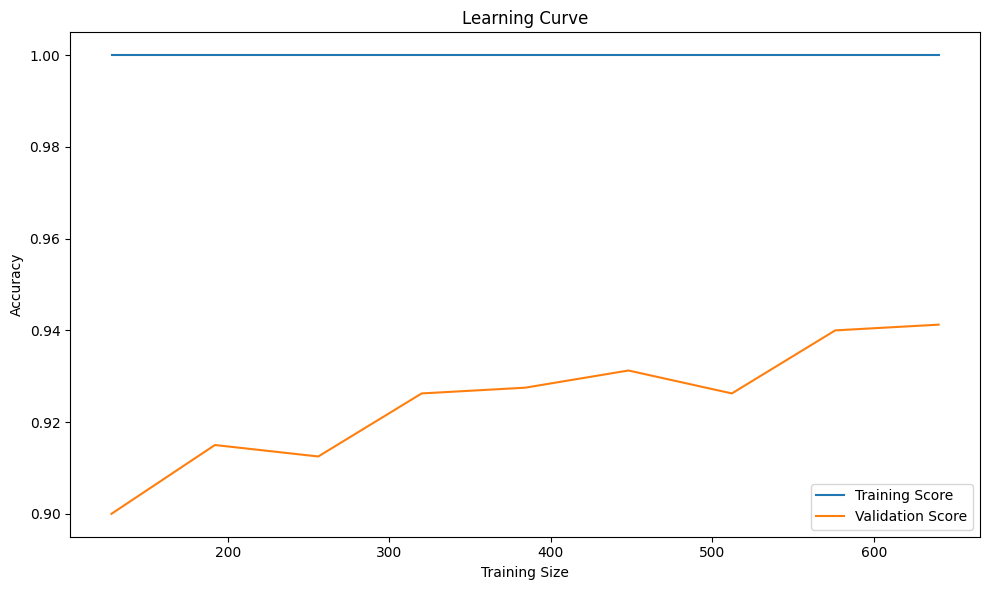

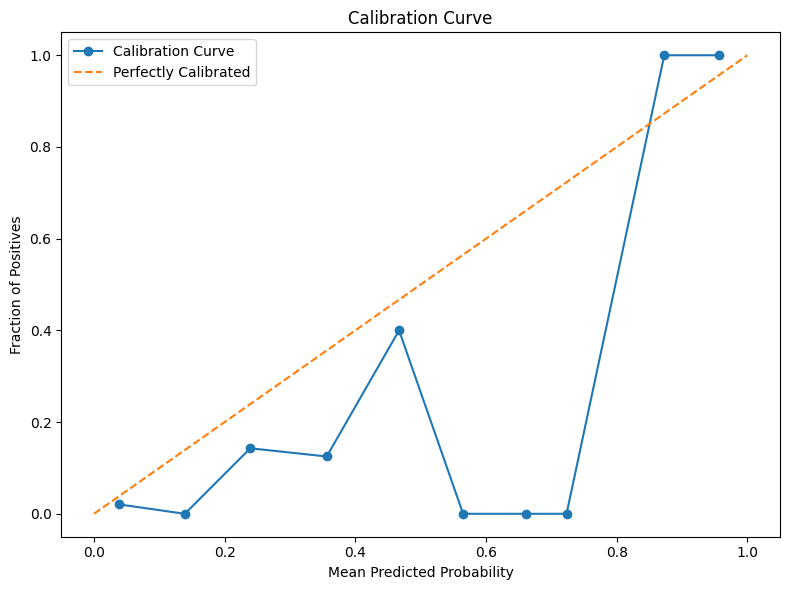

SHAP values for positive class shape: (800, 20)


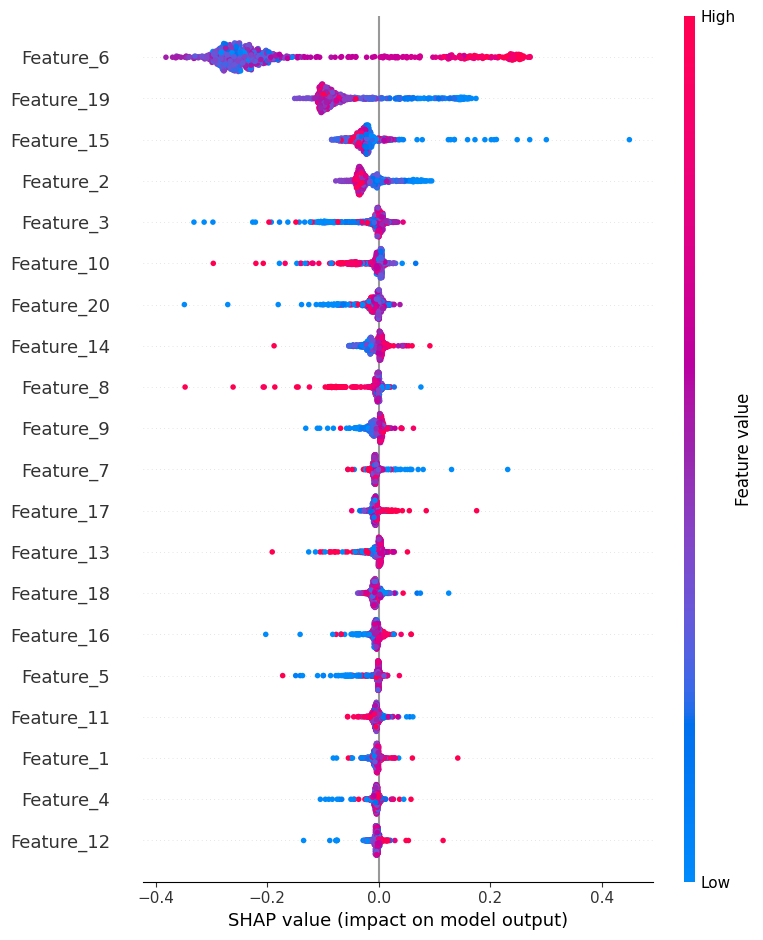

In [2]:
# Import necessary libraries
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.metrics import (
    classification_report,
    ConfusionMatrixDisplay,
    RocCurveDisplay,
    PrecisionRecallDisplay,
)
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
import shap

# Load dataset (replace with your dataset path)
data = pd.read_csv(r'C:\Users\tahsi\OneDrive\Desktop\Research Papers\Sentiment Analysis paper/cleaned_social_media_engagement_data.csv')
target_column = 'Sentiment'  # Define your target column
X = data.drop(columns=[target_column])
y = data[target_column]

# For demonstration purposes, we're creating an imbalanced dataset
X, y = make_classification(n_samples=1000, n_features=20, n_classes=2, weights=[0.9, 0.1], random_state=42)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Define SMOTE with reduced k_neighbors to handle small class sizes
smote = SMOTE(random_state=42, k_neighbors=2)

# Define the pipeline with SMOTE and RandomForestClassifier
pipeline = ImbPipeline([
    ('smote', smote),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_split': [2, 5, 10]
}

# Configure GridSearchCV
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=3,
    n_jobs=-1,
    verbose=2,
    error_score="raise"
)

# Fit the model with GridSearchCV on the training data
grid_search.fit(X_train, y_train)

# Retrieve the best model from grid search
best_model = grid_search.best_estimator_

# Make predictions on the test set
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1] if hasattr(best_model, "predict_proba") else None

# Output the best parameters and the classification report
print("Best Parameters:", grid_search.best_params_)
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Plot confusion matrix
ConfusionMatrixDisplay.from_estimator(best_model, X_test, y_test, cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

# Plot ROC curve (if probabilities are available)
if y_proba is not None:
    RocCurveDisplay.from_predictions(y_test, y_proba)
    plt.title("ROC Curve")
    plt.show()

# Plot Precision-Recall curve
if y_proba is not None:
    PrecisionRecallDisplay.from_predictions(y_test, y_proba)
    plt.title("Precision-Recall Curve")
    plt.show()

# Ensure feature names match the features in X_train
if isinstance(X_train, pd.DataFrame):
    feature_names = X_train.columns.tolist()
else:
    feature_names = [f"Feature_{i+1}" for i in range(X_train.shape[1])]

# Ensure feature_names matches X_train's number of features
assert len(feature_names) == X_train.shape[1], "Mismatch between feature_names and the number of features in X_train."

# Plot feature importance with actual feature names
plt.figure(figsize=(10, 6))
plt.bar(range(len(sorted_indices)), feature_importances[sorted_indices], align='center')
plt.xticks(range(len(sorted_indices)), [feature_names[i] for i in sorted_indices], rotation=90)
plt.title("Feature Importance")
plt.xlabel("Features")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()

# Learning curve
train_sizes, train_scores, test_scores = learning_curve(
    best_model, X_train, y_train, cv=5, scoring='accuracy', n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10)
)
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label="Training Score")
plt.plot(train_sizes, test_scores_mean, label="Validation Score")
plt.title("Learning Curve")
plt.xlabel("Training Size")
plt.ylabel("Accuracy")
plt.legend()
plt.tight_layout()
plt.show()

# Calibration curve
if y_proba is not None:
    prob_true, prob_pred = calibration_curve(y_test, y_proba, n_bins=10, strategy='uniform')

    plt.figure(figsize=(8, 6))
    plt.plot(prob_pred, prob_true, marker='o', label="Calibration Curve")
    plt.plot([0, 1], [0, 1], linestyle="--", label="Perfectly Calibrated")
    plt.title("Calibration Curve")
    plt.xlabel("Mean Predicted Probability")
    plt.ylabel("Fraction of Positives")
    plt.legend()
    plt.tight_layout()
    plt.show()

# SHAP explanation
explainer = shap.TreeExplainer(best_model.named_steps['classifier'])
shap_values = explainer.shap_values(X_train)

# Extract SHAP values for the positive class (class index 1)
shap_values_class = shap_values[:, :, 1]

# Debugging output
print("SHAP values for positive class shape:", shap_values_class.shape)

# Ensure SHAP values align with X_train and feature names
assert shap_values_class.shape == X_train.shape, "Mismatch between SHAP values and X_train."

# SHAP summary plot
shap.summary_plot(shap_values_class, X_train, feature_names=feature_names)
